In this notebook we explore the opportunities for the qubit MILP

Let's first generate a random qiskit circuit.

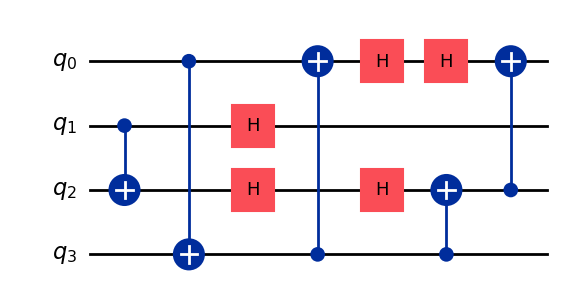

In [1]:
import qiskit.circuit.random
import qiskit.circuit.library.standard_gates

import quariadne.circuit

QUBIT_COUNT = 4
NUM_GATES = 10
SEED = 155
MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h"]


random_circuit = qiskit.circuit.random.random_clifford_circuit(num_qubits=QUBIT_COUNT, num_gates=NUM_GATES, seed=SEED, gates=STANDARD_GATE_SET)
random_circuit.draw(output='mpl')

Let's see what are the circuit properties. For that, let's convert circuit to DAG, and then plot the dag.

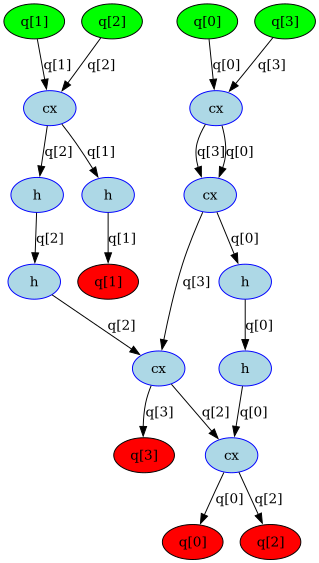

In [2]:
import qiskit.converters
import qiskit.visualization
 
random_circuit_dag = qiskit.converters.circuit_to_dag(random_circuit)
qiskit.visualization.dag_drawer(random_circuit_dag)

Let's check the dot generation actually

In [3]:
random_circuit_dag._to_dot()

'digraph {\n0 ;\n1 ;\n2 ;\n3 ;\n4 ;\n5 ;\n6 ;\n7 ;\n8 ;\n9 ;\n10 ;\n11 ;\n12 ;\n13 ;\n14 ;\n15 ;\n16 ;\n17 ;\n0 -> 9 ;\n2 -> 8 ;\n4 -> 8 ;\n6 -> 9 ;\n8 -> 10 ;\n8 -> 11 ;\n10 -> 12 ;\n9 -> 13 ;\n9 -> 13 ;\n13 -> 14 ;\n12 -> 14 ;\n13 -> 15 ;\n15 -> 16 ;\n14 -> 17 ;\n16 -> 17 ;\n17 -> 5 ;\n17 -> 1 ;\n14 -> 7 ;\n11 -> 3 ;\n}\n'

Okay, pretty useless. Maybe, the edges will help?

In [4]:
list(random_circuit_dag.edges())

[(DAGInNode(wire=<Qubit register=(4, "q"), index=0>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()),
  <Qubit register=(4, "q"), index=0>),
 (DAGInNode(wire=<Qubit register=(4, "q"), index=1>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()),
  <Qubit register=(4, "q"), index=1>),
 (DAGInNode(wire=<Qubit register=(4, "q"), index=2>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()),
  <Qubit register=(4, "q"), index=2>),
 (DAGInNode(wire=<Qubit register=(4, "q"), index=3>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), ca

That's better, but sitll kinda problematic. Maybe let's revert to qasm3.

In [5]:
import qiskit.qasm3


print(qiskit.qasm3.dumps(random_circuit))

OPENQASM 3.0;
include "stdgates.inc";
qubit[4] q;
cx q[1], q[2];
cx q[0], q[3];
h q[2];
h q[1];
h q[2];
cx q[3], q[0];
cx q[3], q[2];
h q[0];
h q[0];
cx q[2], q[0];



Okay, MAYBE NOT. Let's continue fighting with the DAG. Chcecking out the dagdependency. It seems useless for us tbh


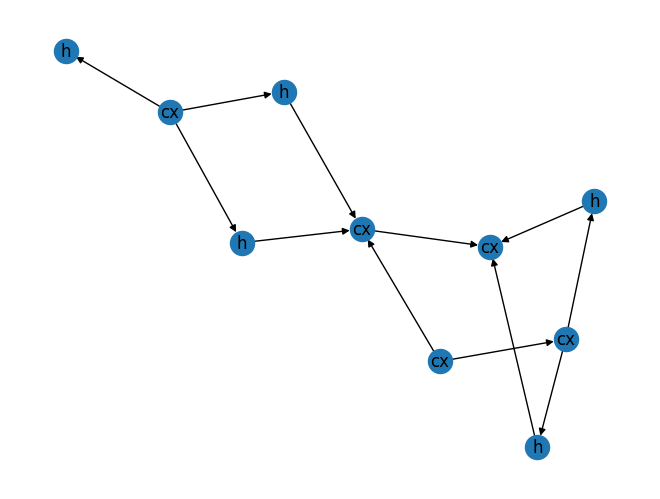

In [6]:
import rustworkx.visualization

random_dag_dependency = qiskit.converters.circuit_to_dagdependency(random_circuit)
random_dag_dependency_rx = random_dag_dependency.to_retworkx()
rustworkx.visualization.mpl_draw(random_dag_dependency_rx, with_labels=True, labels = lambda node: node.name)

random_dag_dependency_rx

Okay, probably the conversion of the original graph is more desired.

In [7]:
random_dag_nodes = list(random_circuit_dag.nodes())
random_dag_nodes

[DAGInNode(wire=<Qubit register=(4, "q"), index=0>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=0>),
 DAGInNode(wire=<Qubit register=(4, "q"), index=1>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=1>),
 DAGInNode(wire=<Qubit register=(4, "q"), index=2>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=2>),
 DAGInNode(wire=<Qubit register=(4, "q"), index=3>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=3>),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=2>,), cargs=()),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "

Some kind of conversion operation should happen here. Let me invent the internal format of that. Maybe initially, simple graph conversion is valid, because I probably won't need a tailoring for a special operations NOW.

Let's select only operations instrutions, and print them.

In [8]:
import qiskit.dagcircuit.dagnode

for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        print(id(node))

140426340633312
140426340632592
140426340632448
140426340632160
140426340632016
140426340631872
140426340631728
140426340631296
140426340637488
140426340637344


Good, now let's see the edges again.

In [9]:
random_dag_edges = list(random_circuit_dag.edges())

for edge in random_dag_edges:
    print(edge)


(DAGInNode(wire=<Qubit register=(4, "q"), index=0>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()), <Qubit register=(4, "q"), index=0>)
(DAGInNode(wire=<Qubit register=(4, "q"), index=1>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()), <Qubit register=(4, "q"), index=1>)
(DAGInNode(wire=<Qubit register=(4, "q"), index=2>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()), <Qubit register=(4, "q"), index=2>)
(DAGInNode(wire=<Qubit register=(4, "q"), index=3>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()), <Qubit regis

Now, let's setup conversion to nx. Let's check also that it is DAG.

In [10]:
import networkx as nx

circuit_dag_routing = nx.DiGraph()
circuit_dag_routing.add_nodes_from(random_dag_nodes)

circuit_dag_edges_nx = [(edge[0], edge[1], {"wire": edge[2]}) for edge in random_dag_edges] # edges in the qiskit formalism are literally in-edge, out-edge and a wire which is the connector
circuit_dag_routing.add_edges_from(circuit_dag_edges_nx)

nx.is_directed_acyclic_graph(circuit_dag_routing)

True

Let's also plot it.

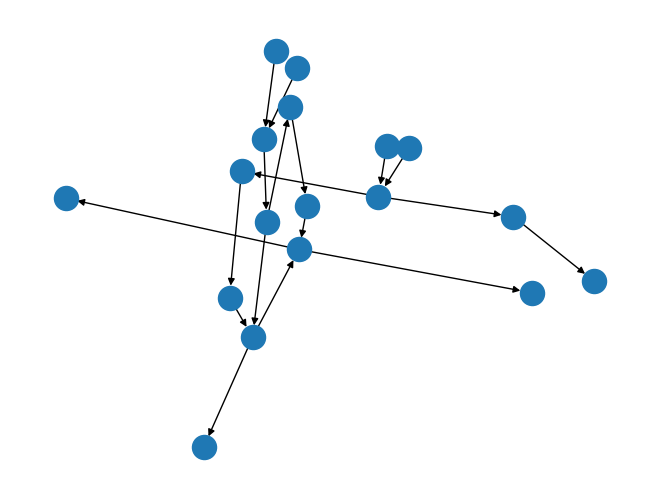

In [11]:
nx.draw(circuit_dag_routing)

Let's draw it a bit better

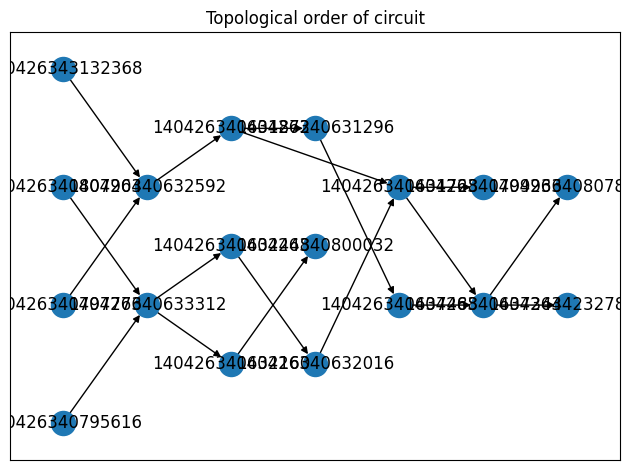

In [12]:
import matplotlib.pyplot as plt

for layer, nodes in enumerate(nx.topological_generations(circuit_dag_routing)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        circuit_dag_routing.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(circuit_dag_routing, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(circuit_dag_routing, pos=pos, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

Let's then also add normal node labels.

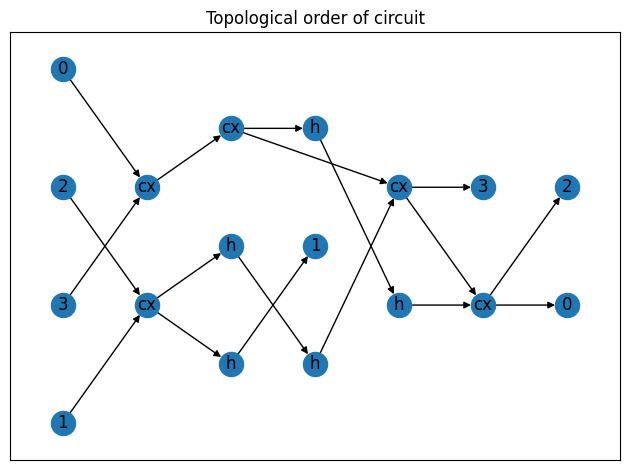

In [13]:
import qiskit.dagcircuit

circuit_labels_by_node = {}
for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        circuit_labels_by_node[node] = node.op.name
    elif isinstance(node, (qiskit.dagcircuit.DAGInNode, qiskit.dagcircuit.DAGOutNode)):
        circuit_labels_by_node[node] = node.wire._index

fig, ax = plt.subplots()
nx.draw_networkx(circuit_dag_routing, pos=pos, ax=ax, labels=circuit_labels_by_node)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

I understood, that I would like to have an intermediate object layer conversion, to make it compatible with other backends. Let's create it with dataclasses.

In [14]:
import dataclasses

@dataclasses.dataclass(frozen=True)
class Qubit:
    is_start: bool
    index: int

@dataclasses.dataclass(frozen=True)
class Gate:
    qubits_participating: int
    name: str
    parent_id: int = dataclasses.field(repr=False)


Qubit(True, 3), Gate(2, "cx", 1) 

(Qubit(is_start=True, index=3), Gate(qubits_participating=2, name='cx'))

Now let's create a set of conversion routines.

In [15]:
random_dag_inner_nodes = []
for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        gate_name = node.op.name
        gate_num_qubits = node.num_qubits
        gate_id = hash(node)
        routing_node = Gate(gate_num_qubits, gate_name, gate_id)
    elif isinstance(node, (qiskit.dagcircuit.DAGInNode, qiskit.dagcircuit.DAGOutNode)):
        qubit_index = node.wire._index
        if isinstance(node, qiskit.dagcircuit.DAGInNode):
            qubit_is_start = True
        elif isinstance(node, qiskit.dagcircuit.DAGOutNode):
            qubit_is_start = False
        routing_node = Qubit(qubit_is_start, qubit_index)
    else: 
        raise NotImplementedError("wrong node type!")
    random_dag_inner_nodes.append(routing_node)

        
    
random_dag_inner_nodes

[Qubit(is_start=True, index=0),
 Qubit(is_start=False, index=0),
 Qubit(is_start=True, index=1),
 Qubit(is_start=False, index=1),
 Qubit(is_start=True, index=2),
 Qubit(is_start=False, index=2),
 Qubit(is_start=True, index=3),
 Qubit(is_start=False, index=3),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='cx')]

Now let's convert the edges. Let's put the previous design into the function, and do the easy conversion here.

In [16]:
import quariadne.computational_graph

routing_edges = []

WIRE_ATTRIBUTE_NAME = "wire"


for edge in random_dag_edges:
    in_node, out_node, wire = edge
    in_routing_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(in_node)
    out_routing_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(out_node)
    routing_edge = (in_routing_node, out_routing_node,)
    routing_edges.append(routing_edge)

routing_edges

[(WireStart(qubit=LogicalQubit(index=0)),
  Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx')),
 (WireStart(qubit=LogicalQubit(index=1)),
  Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx')),
 (WireStart(qubit=LogicalQubit(index=2)),
  Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx')),
 (WireStart(qubit=LogicalQubit(index=3)),
  Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx')),
 (Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'),
  Gate(qubits_participating=(LogicalQubit(index=1),), name='h')),
 (Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'),
  Gate(qubits_participating=(LogicalQubit(index=2),), name='h')),
 (Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'),
  Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0)), name

Here we see a problem, that we don't actually keep track of which logical wire the gate happens on, and probably this should be an important thing as well. Maybe we should deprecate the concept of the Logical qubit? Maybe. Or just creating a timestep based system? Let's try it, but I'd like to keep it simple

In [17]:
import quariadne.computational_graph
import typing


@dataclasses.dataclass
class Transition:
    from_node: quariadne.computational_graph.ComputationalNode
    to_node: quariadne.computational_graph.ComputationalNode
    qubit_index: int


Let's now see the result of our internal representation.

In [18]:
for edge in random_dag_edges:
    in_node, out_node, wire = edge
    wire_index = wire._index
    in_routing_node =  quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(in_node)
    out_routing_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(out_node)
    transition = Transition(in_routing_node, out_routing_node, wire_index)
    print(transition)
    


Transition(from_node=WireStart(qubit=LogicalQubit(index=0)), to_node=Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'), qubit_index=0)
Transition(from_node=WireStart(qubit=LogicalQubit(index=1)), to_node=Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), qubit_index=1)
Transition(from_node=WireStart(qubit=LogicalQubit(index=2)), to_node=Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), qubit_index=2)
Transition(from_node=WireStart(qubit=LogicalQubit(index=3)), to_node=Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'), qubit_index=3)
Transition(from_node=Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), to_node=Gate(qubits_participating=(LogicalQubit(index=1),), name='h'), qubit_index=1)
Transition(from_node=Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), to_node=Gate(qubits_

Hooray, we have our fully internal representation of the routing DAG!!

Now, let's design the full conversion function, for that let's create a final encapsulation for our routing circuit.

In [19]:

@dataclasses.dataclass
class RoutingCircuit:
    nodes: typing.List[quariadne.computational_graph.ComputationalNode]
    transitions: typing.List[quariadne.computational_graph.Transition]



And now, let's design a formation method for this dataclass.

In [20]:
circuit_nodes = []
circuit_transitions = []
for node in random_dag_nodes:
    circuit_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(node)
    circuit_nodes.append(circuit_node)

for edge in random_dag_edges:
    circuit_transition = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_edge(edge)
    circuit_transitions.append(circuit_transition)


random_routing_circuit = RoutingCircuit(circuit_nodes, circuit_transitions)
random_routing_circuit

RoutingCircuit(nodes=[WireStart(qubit=LogicalQubit(index=0)), WireEnd(qubit=LogicalQubit(index=0)), WireStart(qubit=LogicalQubit(index=1)), WireEnd(qubit=LogicalQubit(index=1)), WireStart(qubit=LogicalQubit(index=2)), WireEnd(qubit=LogicalQubit(index=2)), WireStart(qubit=LogicalQubit(index=3)), WireEnd(qubit=LogicalQubit(index=3)), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h'), Gate(qubits_participating=(LogicalQubit(index=1),), name='h'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=0),), name='h'), Gate(qubits_participating=(LogicalQubit(index=0),), name='h'), Gate(qu

Packing everything up, now let's design a conversion of this circuit to nx graph.

In [21]:
random_routing_dag = nx.MultiDiGraph()
random_routing_dag.add_nodes_from(random_routing_circuit.nodes)
random_routing_dag.nodes

NodeView((WireStart(qubit=LogicalQubit(index=0)), WireEnd(qubit=LogicalQubit(index=0)), WireStart(qubit=LogicalQubit(index=1)), WireEnd(qubit=LogicalQubit(index=1)), WireStart(qubit=LogicalQubit(index=2)), WireEnd(qubit=LogicalQubit(index=2)), WireStart(qubit=LogicalQubit(index=3)), WireEnd(qubit=LogicalQubit(index=3)), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h'), Gate(qubits_participating=(LogicalQubit(index=1),), name='h'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=0),), name='h'), Gate(qubits_participating=(LogicalQubit(index=0),), name='h'), Gate(qubits_partici

And now let's make the edges available

In [22]:
transition_as_edges = ((transition.from_node, transition.to_node) for transition in random_routing_circuit.transitions)
random_routing_dag.add_edges_from(transition_as_edges)
random_routing_dag.edges()

OutMultiEdgeDataView([(WireStart(qubit=LogicalQubit(index=0)), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx')), (WireStart(qubit=LogicalQubit(index=1)), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx')), (WireStart(qubit=LogicalQubit(index=2)), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx')), (WireStart(qubit=LogicalQubit(index=3)), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx')), (Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=1),), name='h')), (Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h')), (Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0)), nam

Let's design a function for displaying and plotting. I'll add special attributes for labels

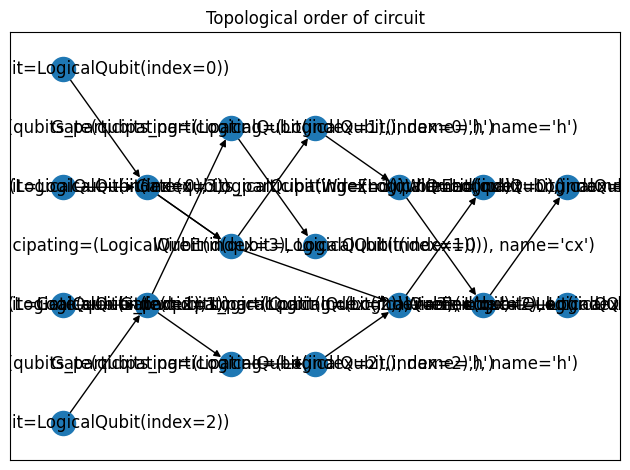

In [23]:
import matplotlib.pyplot as plt


circuit_labels_by_node = {}
for layer, nodes in enumerate(nx.topological_generations(random_routing_dag)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        random_routing_dag.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(random_routing_dag, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(random_routing_dag, pos=pos, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

Not very shiny, let's add some edges and nodes labels. 

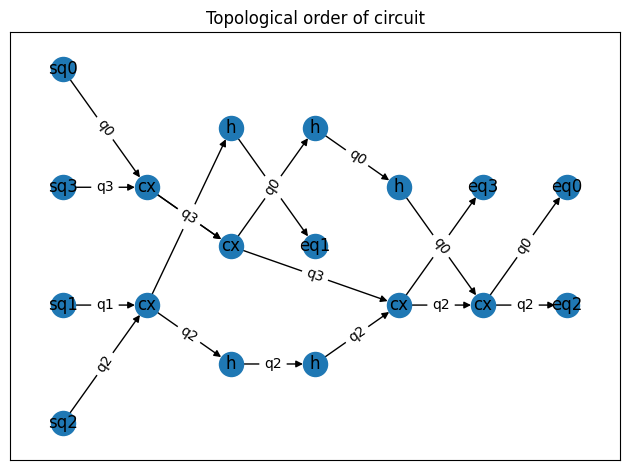

In [24]:
label_by_edge = {}
for transition in random_routing_circuit.transitions:
    edge = transition.as_nx_edge()
    edge_label = f"q{transition.underlying_qubit.index}"
    label_by_edge[edge] = edge_label

label_by_node = {}
for node in random_routing_circuit.nodes:
    label_by_node[node] = node.label


fig, ax = plt.subplots()
nx.draw_networkx(random_routing_dag, pos=pos, ax=ax, labels=label_by_node)
nx.draw_networkx_edge_labels(random_routing_dag,pos=pos, edge_labels=label_by_edge, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()


The only broken thing now is the display of several edges from a gate to another gate, for now I won't treat this problem.

Let's get an exemplar hardware graph now. But first, let's test our inner routing circuit again.

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Visualised DAG'}>)

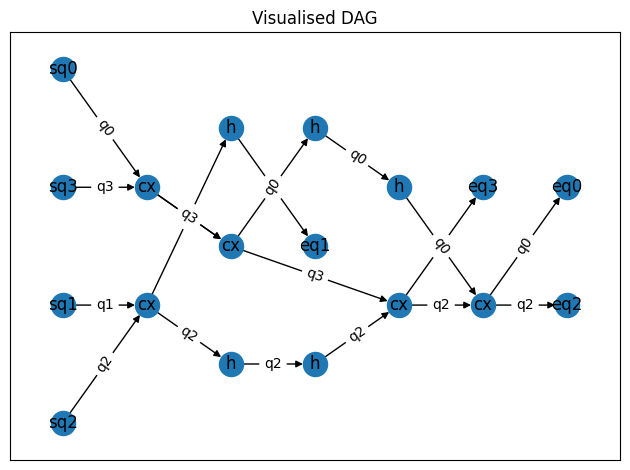

In [25]:
random_routing_circuit = quariadne.computational_graph.ComputationalDAG.from_qiskit_dag(random_circuit_dag)
random_routing_circuit.plot_dag()

Let's then get a generic backend.

In [26]:
import qiskit_ibm_runtime.fake_provider 

manila_backend = qiskit_ibm_runtime.fake_provider.FakeManilaV2()
coupling_graph = manila_backend.coupling_map.graph
coupling_graph

Let's convert it to networkx for now. First though let's visualise it.

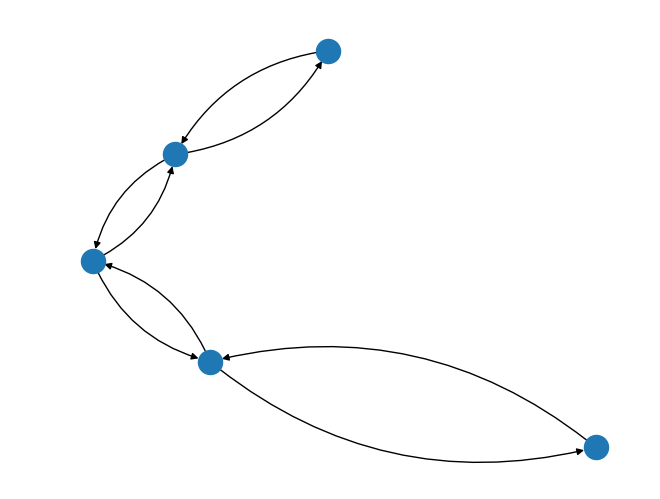

In [27]:
rustworkx.visualization.mpl_draw(coupling_graph)

Then let's get a node and edge list, and visualise the graph.

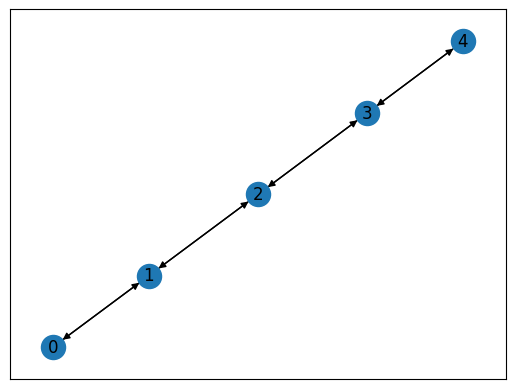

In [28]:
coupling_graph_nx = nx.DiGraph()
coupling_graph_nx.add_nodes_from(coupling_graph.node_indices())
coupling_graph_nx.add_edges_from(coupling_graph.edge_list())
nx.draw_networkx(coupling_graph_nx)

Now the fun part starts, we would like to express this problem as MILP. First, a variable definition. As we remember, the variables participating are:


$w^t_{A,U} = \"\pi^t(A)=u\"$  it is equal to one only if the logical cubit is in the  physical cubit $u$ 


$x^t_{A,u,v} = \" A \text{ goes } u\to v \text{ at time } t$


$y^t_{g,e} = \" \text{gate } g \text{ is executed at time }t \text{ on edge } e$, where edge $e$ is $(u,v)$ 




Let's define the tensor collection, where columns are $t$ time spaced, rows are physical qubits, and the third dimension is the logical qubit. Time spacing is obviously $n^2$ . We see that we need to introduce the circuit itself, making it decoupled from the DAG-like circuit.

In [29]:
type PhysicalByLogicalQubit = dict[circuit.LogicalQubit, circuit.PhysicalQubit]
type GateByLogicalQubit = dict[circuit.LogicalQubit, quariadne.computational_graph.Gate]

@dataclasses.dataclass(frozen=True)
class RoutedCircuit:
    participating_qubits: typing.Tuple[quariadne.circuit.LogicalQubit]
    computational_dag: quariadne.computational_graph.ComputationalDAG
    coupling_map: nx.MultiDiGraph
    qubit_mapping_by_timestep: dict[int, PhysicalByLogicalQubit]
    computational_operation_by_timestep: dict[int, GateByLogicalQubit]

Now let's enable the construction function for ILP specificall, using this class as basis. But first, let's convert to inner format the coupling map as well.

In [30]:
coupling_map_qubits = manila_backend.coupling_map.physical_qubits
physical_qubits = (quariadne.circuit.PhysicalQubit(coupling_map_qubit) for coupling_map_qubit in coupling_map_qubits)
coupling_map_edgelist = manila_backend.coupling_map.graph.edge_list()
physical_qubits_connections = ((quariadne.circuit.PhysicalQubit(coupling_map_from), quariadne.circuit.PhysicalQubit(coupling_map_to)) for coupling_map_from, coupling_map_to in coupling_map_edgelist)
physical_qubits, physical_qubits_connections

(<generator object <genexpr> at 0x7fb76592db10>,
 <generator object <genexpr> at 0x7fb7659c0200>)

And designing a graph.

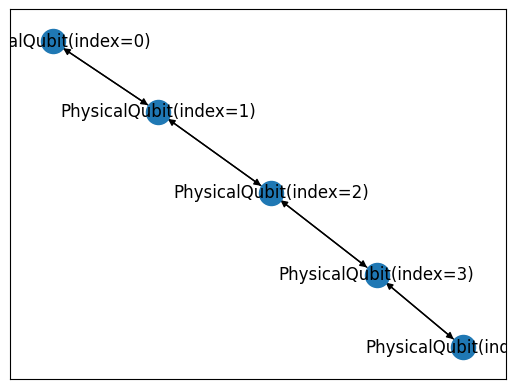

In [31]:
coupling_graph_nx = nx.DiGraph()
coupling_graph_nx.add_nodes_from(physical_qubits)
coupling_graph_nx.add_edges_from(physical_qubits_connections)
nx.draw_networkx(coupling_graph_nx)

Okay, let's continue making the routed circuit possible (for MILP tasks)

In [32]:
computational_operation_by_timestep = {}
initial_spacing = len(random_routing_circuit.nodes)**2
timestep = 0
for topological_generation in nx.topological_generations(random_routing_circuit.to_nx()):
    gate_by_logical_qubit = {}
    for node in topological_generation:
        if isinstance(node, quariadne.computational_graph.Gate):
            for qubit in node.qubits_participating:
                gate_by_logical_qubit[qubit] = node
    computational_operation_by_timestep[timestep] = gate_by_logical_qubit
    timestep+= initial_spacing

computational_operation_by_timestep

{0: {},
 324: {LogicalQubit(index=1): Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'),
  LogicalQubit(index=2): Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'),
  LogicalQubit(index=0): Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx'),
  LogicalQubit(index=3): Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3)), name='cx')},
 648: {LogicalQubit(index=1): Gate(qubits_participating=(LogicalQubit(index=1),), name='h'),
  LogicalQubit(index=2): Gate(qubits_participating=(LogicalQubit(index=2),), name='h'),
  LogicalQubit(index=3): Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0)), name='cx'),
  LogicalQubit(index=0): Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0)), name='cx')},
 972: {LogicalQubit(index=2): Gate(qubits_participating=(LogicalQubit(index=2),), name='h'),
  LogicalQubit(index=0): Gate(qubits_particip

Okay, now we have the material for logical interpretation of the circuit. Let's now design the integer program. First, let's get the random initial mapping. 

In [33]:
import random

computational_timesteps = computational_operation_by_timestep.keys()
starting_timestep = min(computational_timesteps)
ending_timestep = max(computational_timesteps)


But first, let's finally finalise our qubits containing paradigm. For that I'll define a new conceptual block, an abstract circuit, which is a group of operations apriori.

In [34]:
@dataclasses.dataclass(frozen=True)
class QuantumOperation:
    name: str
    qubits_participating: typing.Tuple[quariadne.circuit.LogicalQubit,...]

@dataclasses.dataclass()
class AbstractQuantumCircuit:
    operations: typing.List[QuantumOperation]
    qubits: typing.List[quariadne.circuit.LogicalQubit]

In [35]:
computational_qubits = [quariadne.circuit.LogicalQubit(qubit._index) for qubit in random_circuit.qubits]
operations = []
for instruction in random_circuit.data:
    instruction_operation, instruction_qubits = instruction.operation, instruction.qubits
    quantum_operation_name = instruction_operation.name
    quantum_operation_qubits = tuple(quariadne.circuit.LogicalQubit(qubit._index) for qubit in instruction.qubits)
    quantum_operation = QuantumOperation(quantum_operation_name, quantum_operation_qubits)
    operations.append(quantum_operation)

random_abstract_circuit = AbstractQuantumCircuit(operations, computational_qubits)
random_abstract_circuit

AbstractQuantumCircuit(operations=[QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=3))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=0))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=2))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=0),)), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=0),)), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=2), LogicalQubit(index=0)))], qubits=[LogicalQubit(index=0), LogicalQubit(index=1), LogicalQubit(index=2), LogicalQubit(index=3)]

Now, let's design the conversion of the abstract circuit to the DAG.